# Network analysis
First, import relevant libraries:

In [56]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import *

import igraph as ig # Need to install this in your virtual environment

from re import sub

In [2]:
import sys
sys.path.append('../../src/')
from utils.database import dbutils

conn = dbutils.connect()
cursor = conn.cursor()

Then, load the data (takes a few moments):

In [3]:
df = pd.read_sql('select * from optourism.firenze_card_logs', con=conn)
df.head()

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id
0,2070971,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38
1,2070972,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38
2,2071063,Palazzo Pitti Cumulativo,2016-08-08 11:40:00,0,1,1,0,38
3,2070258,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38
4,2069915,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38


In [4]:
# Helper function for making summary tables/distributions
def frequency(dataframe,columnname):
    out = dataframe[columnname].value_counts().to_frame()
    out.columns = ['frequency']
    out.index.name = columnname
    out.reset_index(inplace=True)
    out.sort_values(columnname,inplace=True)
    out['cumulative'] = out['frequency'].cumsum()/out['frequency'].sum()
    out['ccdf'] = 1 - out['cumulative']
    return out

In [5]:
# Make a two-mode weighted edgelist
df1 = df.groupby(['user_id','museum_name'])['total_adults','minors'].sum()
df1['total_visitors'] = df1['total_adults'] + df1['minors']
df1.reset_index(inplace=True)
df1.drop(['total_adults','minors'], axis=1, inplace=True)
df1.head()

,user_id,museum_name,total_visitors
0,1459702,Basilica di Santa Croce,1
1,1459702,Battistero di San Giovanni,1
2,1459702,Galleria degli Uffizi,1
3,1459702,Galleria dell'Accademia di Firenze,1
4,1459702,Museo Casa Dante,1


In [6]:
g = ig.Graph.TupleList(df1.itertuples(index=False), weights=True) # TupleList is how to get from pandas to igraph

In [7]:
ig.summary(g) # check to make sure the graph imported successfully

IGRAPH UNW- 51073 360522 -- 
+ attr: name (v), weight (e)


In [8]:
g.get_edgelist()[0:20] # There is no longer a head() method, so we have to use usual indexing. 

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (9, 10),
 (2, 9),
 (3, 9),
 (9, 11),
 (8, 9),
 (9, 12),
 (10, 13),
 (2, 13),
 (3, 13),
 (11, 13),
 (8, 13),
 (12, 13)]

In [9]:
g.vs["name"][0:10] # How to see node names. "vs" stands for "vertices"

[1459702,
 'Basilica di Santa Croce',
 'Battistero di San Giovanni',
 'Galleria degli Uffizi',
 "Galleria dell'Accademia di Firenze",
 'Museo Casa Dante',
 'Museo Galileo',
 'Museo Nazionale del Bargello',
 'Museo di Palazzo Vecchio',
 1473903]

In [10]:
g.get_edgelist()[1:10] # How to see edges. They have internal IDs, but for us are referenced as a unique tuple. 

[(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (9, 10), (2, 9)]

In [11]:
g.es["weight"][0:25] # How to see edge properties

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [12]:
# This network has two types of nodes: user_ids, and museums. 
# Python igraph doesn't automatically recognize/track different node types, but
#  fortunately, their names mean we can easily tell them apart: user_ids are 
#  numbers, and museums are not. 
# We associate a "type" attribute with each node, and can use this for 
#  igraph methods for bipartite/two-mode networks. 
g.vs["type"] = [isinstance(name,int)==False for name in g.vs["name"]]

# # This is how to do it taking it into Pandas then coming back out again
# s = pd.Series(g.vs["name"]) # Turn the list into a pandas series
# print s.head()
# print (s.str.isnumeric()==False).astype('int').tolist()[0:9] # Perform an element-wise operation, then take back to a list
# g.vs["type"] = (s.str.isnumeric()==False).tolist()

In [13]:
g.vs["type"][0:10]

[False, True, True, True, True, True, True, True, True, False]

In [14]:
# This turns the affiliation matrix with two types of nodes into a similarity
#  matrix between one of those two types. Similarity here is sharing ties to 
#  nodes of the same type. The user-user similarity matrix is too big to compute,
#  so we only get one of the projections. The output is an undirected, weighted
#  network, where the weights are the number of shared connections to nodes of 
#  the other type. 
g_m = g.bipartite_projection(which=True) 

In [15]:
ig.summary(g_m)

IGRAPH UNWT 42 798 -- 
+ attr: name (v), type (v), weight (e)


In [16]:
# print(g_m) # Gives "adjacency list"

In [17]:
g_m.get_edgelist()[0:10]

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 11),
 (0, 12),
 (0, 8)]

In [18]:
g_m.es["weight"][0:10] # These weights represent the number of user_ids in common

[19153, 17392, 16556, 2891, 6081, 7608, 14815, 9730, 10272, 10668]

In [19]:
# # To do visualizations, run these in your virtual environment
# pip install cffi
# pip install cairocffi

In [20]:
g_m.vs["label"] = g_m.vs["name"] # "label" attribute is used by igraph automatically for naming nodes on plots

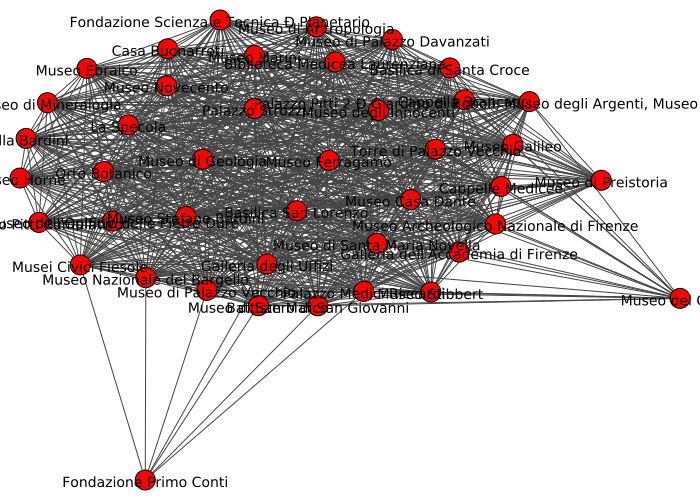

In [21]:
ig.plot(g_m, bbox = (700,500), layout = g_m.layout('kk')) # "kk" is Kamada-Kawai, a standard layout algorithm
# Note that Kamada-Kawai is stochastic, so multiple runs will 
#  generate slightly different graphs (the main difference is 
#  orientation, but the shape differs slightly as well)

In network analysis this is known as the "hairball", or "spaghetti". The usual way around it is, when there are edge weights, to threshold the weights. Let's decide where to threshold. 

In [22]:
fr_ew = frequency(pd.Series(g_m.es["weight"]).to_frame(),0)
fr_ew.head(20)

,0,frequency,cumulative,ccdf
21,1,4,0.005013,0.994987
0,2,17,0.026316,0.973684
27,3,4,0.031328,0.968672
1,4,10,0.043860,0.956140
4,5,8,0.053885,0.946115
15,6,6,0.061404,0.938596
14,7,6,0.068922,0.931078
2,8,10,0.081454,0.918546
34,9,4,0.086466,0.913534
31,10,4,0.091479,0.908521


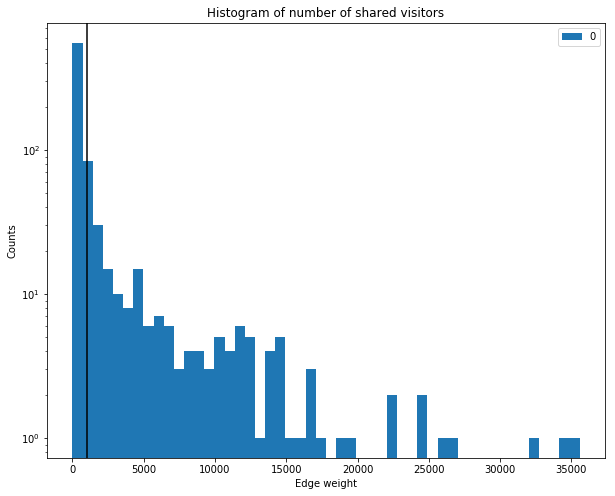

In [25]:
pd.Series(g_m.es["weight"]).to_frame().plot.hist(y=0, logy=True, figsize=(10,8), bins=50)
plt.ylabel('Counts')
plt.xlabel('Edge weight')
plt.title('Histogram of number of shared visitors')
plt.axvline(1000,color="black") # I decided to use 1000. A round number, cuts off the peak of the histogram, and works well below. 
# plt.savefig('shared_visitors.png')
plt.show()

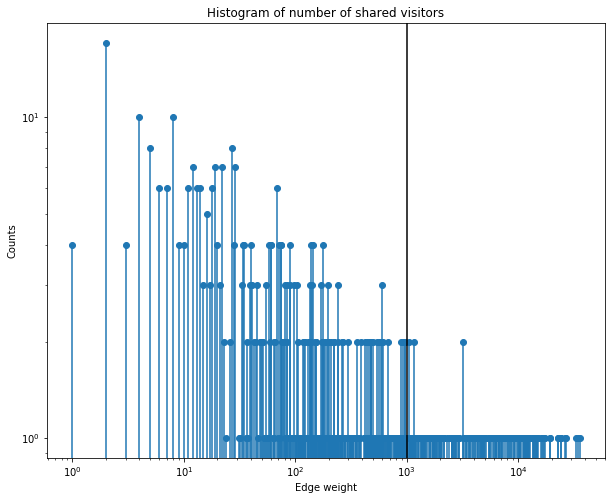

In [26]:
# This is messier but gives more justification to using 1000; that's before there are uniquely large edge weights.
# Maybe it should be a bit larger than 1000, but it's the nearest round number. 
f, ax = plt.subplots(figsize=(10,8)) #, dpi=300)
ax.stem(fr_ew[0],fr_ew['frequency'], linestyle='steps--')
yscale('log')
xscale('log')
ax.set_title('Histogram of number of shared visitors')
ax.set_ylabel('Counts')
ax.set_xlabel('Edge weight')
plt.axvline(1000,color="black")
plt.show()

In [27]:
# # CDF plot. Not helpful.
# f, ax = plt.subplots(figsize=(10,8)) #, dpi=300)
# ax.plot(fr_ew[0],fr_ew['cumulative'])
# # yscale('log')
# # xscale('log')
# ax.set_title('Shared visitors')
# ax.set_ylabel('Fraction of edges with weight x or less')
# ax.set_xlabel('Weight')
# plt.show()

In [28]:
# # CCDF/Survival function plot. Not helpful.
# f, ax = plt.subplots(figsize=(10,8)) #, dpi=300)
# ax.plot(fr_ew[0],fr_ew['ccdf'])
# # yscale('log')
# # xscale('log')
# ax.set_title('Shared visitors')
# ax.set_ylabel('Fraction of edges with weight x or greater')
# ax.set_xlabel('Weight')
# plt.show()

In [29]:
ig.summary(g_m) # How many edges are there initially?

IGRAPH UNWT 42 798 -- 
+ attr: label (v), name (v), type (v), weight (e)


In [30]:
g_m.es.select(weight_lt=1000).delete() # Deletes edges with weights under 1000. Modifies graph object in place. 
ig.summary(g_m) # See the result. 798 edges to 194. 

IGRAPH UNWT 42 194 -- 
+ attr: label (v), name (v), type (v), weight (e)


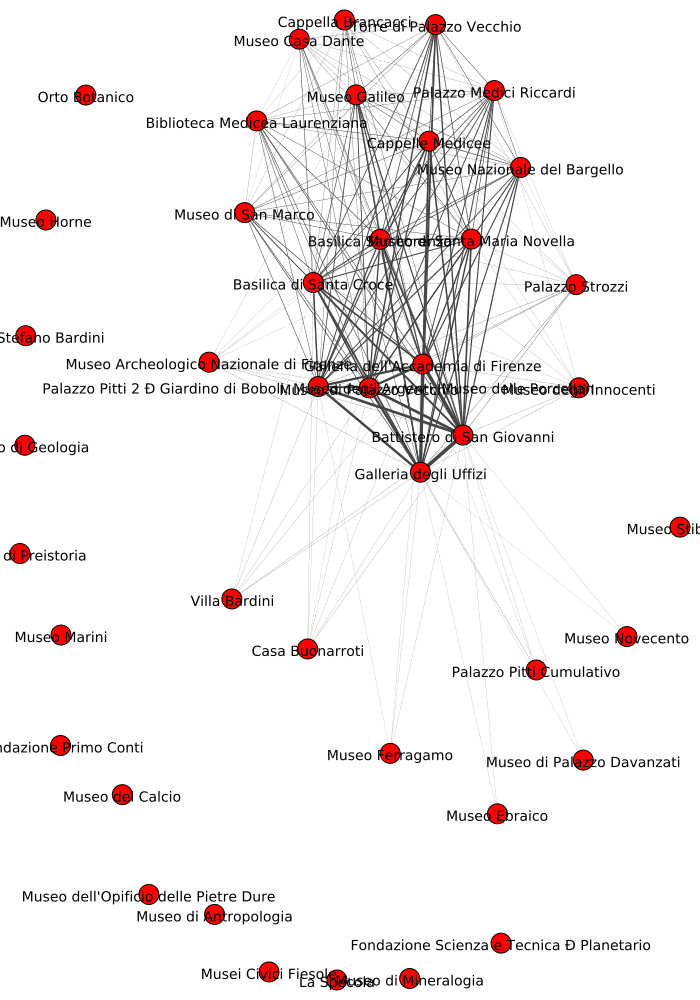

In [31]:
visual_style = {}
visual_style["edge_width"] = [.0001*i for i in g_m.es["weight"]] # Scale weights
ig.plot(g_m, bbox = (700,1000), layout = g_m.layout('kk'), **visual_style)

This visually suggests a "core-periphery structure"; this matches with our notion of how the museums work. There is a more formal way of modeling core-periphery structure, but it's not terribly useful: it can quantify the levels of core-ness and periphery-ness, but that doesn't give anything particularly interpretable.

Next, I propose distinguishing _paths_ from _flows_. A path is an itinerary, and the flow is the number of people who take the flow. E.g., a family or a tour group produces one path, but adds mulitple people to the overall flow. 

I have this projection of the affiliation/bipartite/two-mode network. But what I need is a transition graph, a directed graph where an edge represents a person going from one museum to another *within the same day*. Write code for that now. 

Also, produce the transition matrix. Actually, maybe I should do that, and make the graph from that as an adjacency matrix.

# Other exploratory/summary plots

In [32]:
df2 = df.groupby('museum_name').sum()[['total_adults','minors']]
df2['total_people'] = df2['total_adults'] + df2['minors']
df2.sort_values('total_people',inplace=True,ascending=False)
df2.head()

,total_adults,minors,total_people
museum_name,,,
Battistero di San Giovanni,44047,5842,49889
Galleria degli Uffizi,40622,3717,44339
Galleria dell'Accademia di Firenze,39364,3053,42417
Museo di Palazzo Vecchio,29403,3354,32757
"Palazzo Pitti 2 Ð Giardino di Boboli, Museo degli Argenti, Museo delle Porcellan",29142,3155,32297


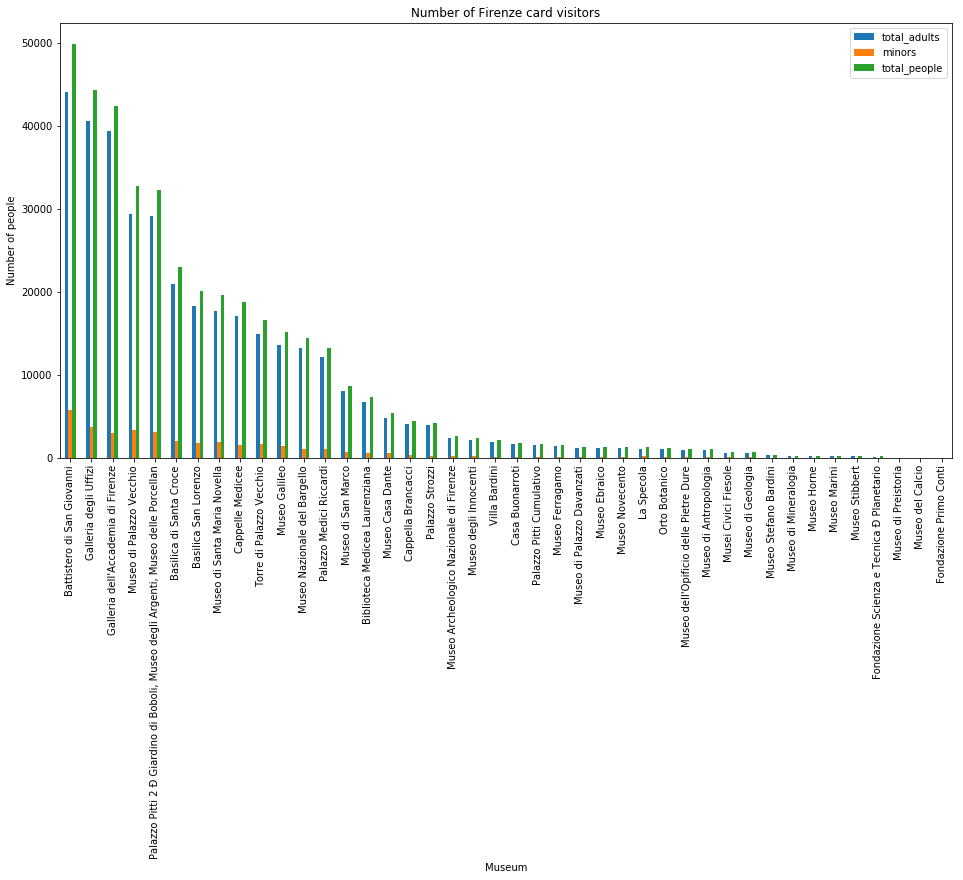

In [35]:
df2.plot.bar(figsize=(16,8))
plt.title('Number of Firenze card visitors')
plt.xlabel('Museum')
plt.ylabel('Number of people')
# plt.yscale('log')
plt.show()

# Transition/Origin-Destination (OD) matrix 

In [36]:
df['date'] = pd.to_datetime(df['entry_time'], format='%Y-%m-%d %H:%M:%S').dt.date
df.head(10)

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,museum_id,date
0,2070971,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38,2016-08-08
1,2070972,Palazzo Pitti Cumulativo,2016-08-08 11:25:00,0,1,1,0,38,2016-08-08
2,2071063,Palazzo Pitti Cumulativo,2016-08-08 11:40:00,0,1,1,0,38,2016-08-08
3,2070258,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38,2016-08-08
4,2069915,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38,2016-08-08
5,2070259,Palazzo Pitti Cumulativo,2016-08-08 11:43:00,0,1,1,0,38,2016-08-08
6,2069914,Palazzo Pitti Cumulativo,2016-08-08 11:44:00,0,1,1,0,38,2016-08-08
7,2070281,Palazzo Pitti Cumulativo,2016-08-08 11:44:00,0,1,1,0,38,2016-08-08
8,2069988,Palazzo Pitti Cumulativo,2016-08-08 11:47:00,0,1,1,0,38,2016-08-08
9,2069989,Palazzo Pitti Cumulativo,2016-08-08 11:48:00,0,1,1,0,38,2016-08-08


In [37]:
df3 = df.sort_values(['user_id','entry_time'],ascending=False,inplace=False)
df3.reset_index(inplace=True)
df3.drop(['index','museum_id'], axis=1, inplace=True)
df3.head()

,user_id,museum_name,entry_time,adults_first_use,adults_reuse,total_adults,minors,date
0,2095767,Battistero di San Giovanni,2016-09-30 17:55:00,1,0,1,0,2016-09-30
1,2095766,Battistero di San Giovanni,2016-09-30 17:55:00,1,0,1,0,2016-09-30
2,2095765,Battistero di San Giovanni,2016-09-30 17:24:00,1,0,1,0,2016-09-30
3,2095765,Battistero di San Giovanni,2016-09-30 17:24:00,0,0,0,1,2016-09-30
4,2095764,Museo di Palazzo Vecchio,2016-09-30 17:31:00,1,0,1,0,2016-09-30


Now, we make a graph of the transitions for museums. To do this, we make an edgelist out of the above. 

Specifically, we want an edgelist where the first column is the origin site, the second column is the destination site, the third column is the number of people (total adults plus rows for minors), and the fourth column is the time stamp of the entry to the _destination_ museum. 

But, there's a twist. We want to track when people arrive at the first museum of their day. We can do this by adding a dummy "source" node that everybody starts each day from. We can then query this dummy node to see not only which museum people activate their Firenze card from, but also the museum where they start their other days. For visualizations, we can drop it (or not visualize it). 

We could also have people return to this source node at the end of each day (or make a separate "target" node for this purpose), but there would be no timestamp for that arrival so it would complicate the data with missing values. However, we might still want to do this, analogously to find the last museum people tend to visit in a day. 

I will create this source node by the following: first, create an indicator for if the previous record is the same day and the same Firenze card. If it is, we make a link from the museum of the previous row and the museum of that row. 

If the previous row is either a different day and/or a different user_id, make a link between the dummy "source" node and that row's museum. 

I do this below in a different order: I initialize a "from" column with all source, then overwrite with the museum of the previous row if the conditions are met. 

In [38]:
df4 = df3.groupby(['user_id','entry_time','date','museum_name']).sum() # Need to group in this order to be correct further down
df4['total_people'] = df4['total_adults'] + df4['minors']
df4.head()

adults_first_use  \
user_id entry_time          date       museum_name                                            
1459702 2016-06-22 10:04:00 2016-06-22 Galleria degli Uffizi                              1   
        2016-06-22 14:26:00 2016-06-22 Museo Casa Dante                                   0   
        2016-06-22 15:49:00 2016-06-22 Galleria dell'Accademia di Firenze                 0   
        2016-06-23 09:43:00 2016-06-23 Battistero di San Giovanni                         0   
        2016-06-23 11:14:00 2016-06-23 Museo Galileo                                      0   

                                                                           adults_reuse  \
user_id entry_time          date       museum_name                                        
1459702 2016-06-22 10:04:00 2016-06-22 Galleria degli Uffizi                          0   
        2016-06-22 14:26:00 2016-06-22 Museo Casa Dante                               1   
        2016-06-22 15:49:00 2016-06-22 Galleria dell'Accademia di Firenze             1   
        2016-06-23 09:43:00 2016-06-23 Battistero di San Giovanni                     1   
        2016-06-23 11:14:00 2016-06-23 Museo Galileo                                  1   

                                                                           total_adults  \
user_id entry_time          date       museum_name                                        
1459702 2016-06-22 10:04:00 2016-06-22 Galleria degli Uffizi                          1   
        2016-06-22 14:26:00 2016-06-22 Museo Casa Dante                               1   
        2016-06-22 15:49:00 2016-06-22 Galleria dell'Accademia di Firenze             1   
        2016-06-23 09:43:00 2016-06-23 Battistero di San Giovanni                     1   
        2016-06-23 11:14:00 2016-06-23 Museo Galileo                                  1   

                                                                           minors  \
user_id entry_time          date       museum_name                                  
1459702 2016-06-22 10:04:00 2016-06-22 Galleria degli Uffizi                    0   
        2016-06-22 14:26:00 2016-06-22 Museo Casa Dante                         0   
        2016-06-22 15:49:00 2016-06-22 Galleria dell'Accademia di Firenze       0   
        2016-06-23 09:43:00 2016-06-23 Battistero di San Giovanni               0   
        2016-06-23 11:14:00 2016-06-23 Museo Galileo                            0   

                                                                           total_people  
user_id entry_time          date       museum_name                                       
1459702 2016-06-22 10:04:00 2016-06-22 Galleria degli Uffizi                          1  
        2016-06-22 14:26:00 2016-06-22 Museo Casa Dante                               1  
        2016-06-22 15:49:00 2016-06-22 Galleria dell'Accademia di Firenze             1  
        2016-06-23 09:43:00 2016-06-23 Battistero di San Giovanni                     1  
        2016-06-23 11:14:00 2016-06-23 Museo Galileo                                  1

In [39]:
df3.groupby(['user_id','date','museum_name','entry_time']).sum().head(10) # Even though this grouping's multiindex looks nicer

adults_first_use  \
user_id date       museum_name                        entry_time                              
1459702 2016-06-22 Galleria degli Uffizi              2016-06-22 10:04:00                 1   
                   Galleria dell'Accademia di Firenze 2016-06-22 15:49:00                 0   
                   Museo Casa Dante                   2016-06-22 14:26:00                 0   
        2016-06-23 Basilica di Santa Croce            2016-06-23 15:05:00                 0   
                   Battistero di San Giovanni         2016-06-23 09:43:00                 0   
                   Museo Galileo                      2016-06-23 11:14:00                 0   
                   Museo Nazionale del Bargello       2016-06-23 13:41:00                 0   
                   Museo di Palazzo Vecchio           2016-06-23 12:57:00                 0   
1473903 2016-06-19 Galleria degli Uffizi              2016-06-19 11:24:00                 1   
        2016-06-20 Basilica San Lorenzo               2016-06-20 15:44:00                 0   

                                                                           adults_reuse  \
user_id date       museum_name                        entry_time                          
1459702 2016-06-22 Galleria degli Uffizi              2016-06-22 10:04:00             0   
                   Galleria dell'Accademia di Firenze 2016-06-22 15:49:00             1   
                   Museo Casa Dante                   2016-06-22 14:26:00             1   
        2016-06-23 Basilica di Santa Croce            2016-06-23 15:05:00             1   
                   Battistero di San Giovanni         2016-06-23 09:43:00             1   
                   Museo Galileo                      2016-06-23 11:14:00             1   
                   Museo Nazionale del Bargello       2016-06-23 13:41:00             1   
                   Museo di Palazzo Vecchio           2016-06-23 12:57:00             1   
1473903 2016-06-19 Galleria degli Uffizi              2016-06-19 11:24:00             0   
        2016-06-20 Basilica San Lorenzo               2016-06-20 15:44:00             1   

                                                                           total_adults  \
user_id date       museum_name                        entry_time                          
1459702 2016-06-22 Galleria degli Uffizi              2016-06-22 10:04:00             1   
                   Galleria dell'Accademia di Firenze 2016-06-22 15:49:00             1   
                   Museo Casa Dante                   2016-06-22 14:26:00             1   
        2016-06-23 Basilica di Santa Croce            2016-06-23 15:05:00             1   
                   Battistero di San Giovanni         2016-06-23 09:43:00             1   
                   Museo Galileo                      2016-06-23 11:14:00             1   
                   Museo Nazionale del Bargello       2016-06-23 13:41:00             1   
                   Museo di Palazzo Vecchio           2016-06-23 12:57:00             1   
1473903 2016-06-19 Galleria degli Uffizi              2016-06-19 11:24:00             1   
        2016-06-20 Basilica San Lorenzo               2016-06-20 15:44:00             1   

                                                                           minors  
user_id date       museum_name                        entry_time                   
1459702 2016-06-22 Galleria degli Uffizi              2016-06-22 10:04:00       0  
                   Galleria dell'Accademia di Firenze 2016-06-22 15:49:00       0  
                   Museo Casa Dante                   2016-06-22 14:26:00       0  
        2016-06-23 Basilica di Santa Croce            2016-06-23 15:05:00       0  
                   Battistero di San Giovanni         2016-06-23 09:43:00       0  
                   Museo Galileo                      2016-06-23 11:14:00       0  
                   Museo Nazionale del Bargello       2016-06-23 13:41:00   

In [40]:
df4.reset_index(inplace=True)
df4.head(10)

,user_id,entry_time,date,museum_name,adults_first_use,adults_reuse,total_adults,minors,total_people
0,1459702,2016-06-22 10:04:00,2016-06-22,Galleria degli Uffizi,1,0,1,0,1
1,1459702,2016-06-22 14:26:00,2016-06-22,Museo Casa Dante,0,1,1,0,1
2,1459702,2016-06-22 15:49:00,2016-06-22,Galleria dell'Accademia di Firenze,0,1,1,0,1
3,1459702,2016-06-23 09:43:00,2016-06-23,Battistero di San Giovanni,0,1,1,0,1
4,1459702,2016-06-23 11:14:00,2016-06-23,Museo Galileo,0,1,1,0,1
5,1459702,2016-06-23 12:57:00,2016-06-23,Museo di Palazzo Vecchio,0,1,1,0,1
6,1459702,2016-06-23 13:41:00,2016-06-23,Museo Nazionale del Bargello,0,1,1,0,1
7,1459702,2016-06-23 15:05:00,2016-06-23,Basilica di Santa Croce,0,1,1,0,1
8,1473903,2016-06-19 11:24:00,2016-06-19,Galleria degli Uffizi,1,0,1,0,1
9,1473903,2016-06-20 12:05:00,2016-06-20,Battistero di San Giovanni,0,1,1,0,1


In [41]:
df4['from'] = u'source' # Initialize 'from' column with 'source'
df4['to'] = df4['museum_name'] # Copy 'to' column with row's museum_name

df4.head(10)

,user_id,entry_time,date,museum_name,adults_first_use,adults_reuse,total_adults,minors,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,Galleria degli Uffizi,1,0,1,0,1,source,Galleria degli Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,Museo Casa Dante,0,1,1,0,1,source,Museo Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,Galleria dell'Accademia di Firenze,0,1,1,0,1,source,Galleria dell'Accademia di Firenze
3,1459702,2016-06-23 09:43:00,2016-06-23,Battistero di San Giovanni,0,1,1,0,1,source,Battistero di San Giovanni
4,1459702,2016-06-23 11:14:00,2016-06-23,Museo Galileo,0,1,1,0,1,source,Museo Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,Museo di Palazzo Vecchio,0,1,1,0,1,source,Museo di Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,Museo Nazionale del Bargello,0,1,1,0,1,source,Museo Nazionale del Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,Basilica di Santa Croce,0,1,1,0,1,source,Basilica di Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,Galleria degli Uffizi,1,0,1,0,1,source,Galleria degli Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,Battistero di San Giovanni,0,1,1,0,1,source,Battistero di San Giovanni


In [143]:
make_link = (df4['user_id'].shift(1)==df4['user_id'])&(df4['date'].shift(1)==df4['date']) # Row indexes at which to overwrite 'source'
df4['from'][make_link] = df4['museum_name'].shift(1)[make_link]
df4.head(50)

,user_id,entry_time,date,museum_name,adults_first_use,adults_reuse,total_adults,minors,total_people,from,to
0,1459702,2016-06-22 10:04:00,2016-06-22,Galleria degli Uffizi,1,0,1,0,1,source,Galleria degli Uffizi
1,1459702,2016-06-22 14:26:00,2016-06-22,Museo Casa Dante,0,1,1,0,1,Galleria degli Uffizi,Museo Casa Dante
2,1459702,2016-06-22 15:49:00,2016-06-22,Galleria dell'Accademia di Firenze,0,1,1,0,1,Museo Casa Dante,Galleria dell'Accademia di Firenze
3,1459702,2016-06-23 09:43:00,2016-06-23,Battistero di San Giovanni,0,1,1,0,1,source,Battistero di San Giovanni
4,1459702,2016-06-23 11:14:00,2016-06-23,Museo Galileo,0,1,1,0,1,Battistero di San Giovanni,Museo Galileo
5,1459702,2016-06-23 12:57:00,2016-06-23,Museo di Palazzo Vecchio,0,1,1,0,1,Museo Galileo,Museo di Palazzo Vecchio
6,1459702,2016-06-23 13:41:00,2016-06-23,Museo Nazionale del Bargello,0,1,1,0,1,Museo di Palazzo Vecchio,Museo Nazionale del Bargello
7,1459702,2016-06-23 15:05:00,2016-06-23,Basilica di Santa Croce,0,1,1,0,1,Museo Nazionale del Bargello,Basilica di Santa Croce
8,1473903,2016-06-19 11:24:00,2016-06-19,Galleria degli Uffizi,1,0,1,0,1,source,Galleria degli Uffizi
9,1473903,2016-06-20 12:05:00,2016-06-20,Battistero di San Giovanni,0,1,1,0,1,source,Battistero di San Giovanni


In [43]:
# df4[df4['user_id']==2016016] # Do a check: before, my incorrect groupby order caused artifacts. 

In [44]:
# df4[(df4['from']=="Galleria dell'Accademia di Firenze")&(df4['to']=="Galleria degli Uffizi")] # Before, this result was empty

In [45]:
# # This manually checked the above result, to make sure I didn't make a mistake in creating the columns
# df4[((df4['museum_name'].shift(1)=="Galleria dell'Accademia di Firenze")\
#      &(df4['museum_name']=="Galleria degli Uffizi")\
#      &(df4['user_id']==df4['user_id'].shift(1))
#      &(df4['date']==df4['date'].shift(1))
#     )\
#    | \
#     ((df4['museum_name']=="Galleria dell'Accademia di Firenze")\
#      &(df4['museum_name'].shift(-1)=="Galleria degli Uffizi")\
#      &(df4['user_id']==df4['user_id'].shift(-1))
#      &(df4['date']==df4['date'].shift(-1))
#     )]

In [46]:
# df4[(df4['to']=="Galleria dell'Accademia di Firenze")&(df4['from']=="Galleria degli Uffizi")] # Once the above was finished, had to make sure the opposite problem didn't happen

In [47]:
# Create the actual edgelist for the transition matrix (of a first-order Markov chain)
df5 = df4.groupby(['from','to'])['total_people'].sum().to_frame()
df5.columns = ['weight']
df5.reset_index(inplace=True)
df5.head(10)

,from,to,weight
0,Basilica San Lorenzo,Basilica San Lorenzo,1
1,Basilica San Lorenzo,Basilica di Santa Croce,521
2,Basilica San Lorenzo,Battistero di San Giovanni,1282
3,Basilica San Lorenzo,Biblioteca Medicea Laurenziana,2528
4,Basilica San Lorenzo,Cappella Brancacci,60
5,Basilica San Lorenzo,Cappelle Medicee,4519
6,Basilica San Lorenzo,Casa Buonarroti,43
7,Basilica San Lorenzo,Fondazione Scienza e Tecnica Ð Planetario,3
8,Basilica San Lorenzo,Galleria degli Uffizi,457
9,Basilica San Lorenzo,Galleria dell'Accademia di Firenze,1235


In [48]:
# Create and check the graph
g2 = ig.Graph.TupleList(df5.itertuples(index=False), directed=True, weights=True)
ig.summary(g2)

IGRAPH DNW- 43 1293 -- 
+ attr: name (v), weight (e)


In [49]:
g2.vs['name']

['Basilica San Lorenzo',
 'Basilica di Santa Croce',
 'Battistero di San Giovanni',
 'Biblioteca Medicea Laurenziana',
 'Cappella Brancacci',
 'Cappelle Medicee',
 'Casa Buonarroti',
 'Fondazione Scienza e Tecnica \xc3\x90 Planetario',
 'Galleria degli Uffizi',
 "Galleria dell'Accademia di Firenze",
 'La Specola',
 'Musei Civici Fiesole',
 'Museo Archeologico Nazionale di Firenze',
 'Museo Casa Dante',
 'Museo Ebraico',
 'Museo Ferragamo',
 'Museo Galileo',
 'Museo Horne',
 'Museo Marini',
 'Museo Nazionale del Bargello',
 'Museo Novecento',
 'Museo Stefano Bardini',
 'Museo Stibbert',
 'Museo degli Innocenti',
 "Museo dell'Opificio delle Pietre Dure",
 'Museo di Antropologia',
 'Museo di Geologia',
 'Museo di Mineralogia',
 'Museo di Palazzo Davanzati',
 'Museo di Palazzo Vecchio',
 'Museo di San Marco',
 'Museo di Santa Maria Novella',
 'Orto Botanico',
 'Palazzo Medici Riccardi',
 'Palazzo Pitti 2 \xc3\x90 Giardino di Boboli, Museo degli Argenti, Museo delle Porcellan',
 'Palazzo Pi

In [91]:
# Put in graph attributes to help with plotting
g2.vs['label'] = g2.vs["name"] # [sub("'","",i.decode('unicode_escape').encode('ascii','ignore')) for i in g2.vs["name"]] # Is getting messed up!
g2.vs['size'] = [.00075*i for i in g2.strength(mode='in',weights='weight')] # .00075 is from hand-tuning

In [92]:
g2.vs['label']

['Basilica San Lorenzo',
 'Basilica di Santa Croce',
 'Battistero di San Giovanni',
 'Biblioteca Medicea Laurenziana',
 'Cappella Brancacci',
 'Cappelle Medicee',
 'Casa Buonarroti',
 'Fondazione Scienza e Tecnica \xc3\x90 Planetario',
 'Galleria degli Uffizi',
 "Galleria dell'Accademia di Firenze",
 'La Specola',
 'Musei Civici Fiesole',
 'Museo Archeologico Nazionale di Firenze',
 'Museo Casa Dante',
 'Museo Ebraico',
 'Museo Ferragamo',
 'Museo Galileo',
 'Museo Horne',
 'Museo Marini',
 'Museo Nazionale del Bargello',
 'Museo Novecento',
 'Museo Stefano Bardini',
 'Museo Stibbert',
 'Museo degli Innocenti',
 "Museo dell'Opificio delle Pietre Dure",
 'Museo di Antropologia',
 'Museo di Geologia',
 'Museo di Mineralogia',
 'Museo di Palazzo Davanzati',
 'Museo di Palazzo Vecchio',
 'Museo di San Marco',
 'Museo di Santa Maria Novella',
 'Orto Botanico',
 'Palazzo Medici Riccardi',
 'Palazzo Pitti 2 \xc3\x90 Giardino di Boboli, Museo degli Argenti, Museo delle Porcellan',
 'Palazzo Pi

In [114]:
layout = g2.layout('lgl')

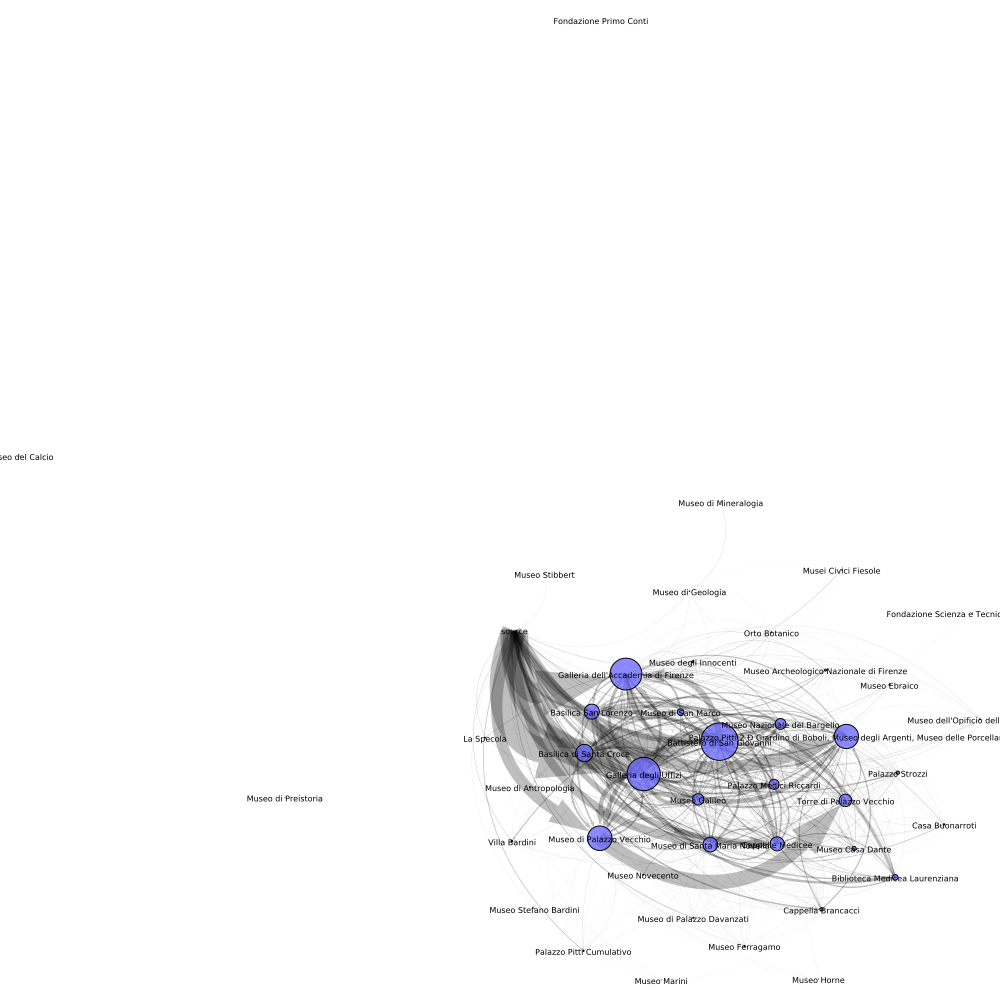

In [142]:
visual_style = {}
visual_style["edge_width"] = [.001*i for i in g2.es["weight"]] # Scale weights. .001*i chosen by hand. Try also .05*np.sqrt(i)
visual_style['edge_arrow_size'] = [.00025*i for i in g2.es["weight"]] # .00025*i chosen by hand. Try also .01*np.sqrt(i)
visual_style['vertex_label_size'] = 8
visual_style['vertex_color'] = "rgba(100, 100, 255, .75)"
visual_style['edge_color'] = "rgba(0, 0, 0, .25)"
visual_style['edge_curved'] = True
# ig.plot(g2, bbox = (700,1000), layout = layout, margin=20, **visual_style)
ig.plot(g2, 'graph.svg', bbox = (1000,1000), **visual_style)

In [ ]:
# print(g2.get_adjacency()) # This was another check; before it was very nearly upper triangular. Now it looks much better. Copy into a text editor and resize to see the whole matrix.

In [128]:
transition_matrix = pd.DataFrame(g2.get_adjacency(attribute='weight').data, columns=g2.vs['name'], index=g2.vs['name'])

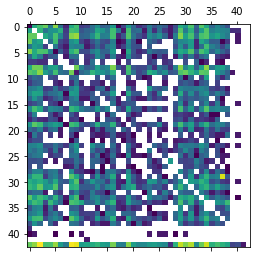

In [132]:
plt.matshow(np.log(transition_matrix))